In [1]:
# load in required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import shap
import re
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, linear_model
from xgboost import XGBClassifier, XGBRegressor
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
def get_df(feature_name,feature_label):

    df_combine=pd.DataFrame(columns=['City','Feature','Mode','Feature_value','Shap_y','Zero'])

    for city in ['Berlin','France_other','Germany_other','Madrid','Paris','Wien']: #  
        print(city)

        fp='../outputs/ML_Results/shap/mode_common_new/' + city + '_df.pkl'
        with open(fp, 'rb') as f:
            df=pickle.load(f)
        target = 'Mode_num'

        X=df[[col for col in df.columns if "FeatureM" in col]]
        y = df[target]
        fp='../outputs/ML_Results/shap/mode_common_new/' + city + '.pkl'
        with open(fp, 'rb') as f:
            shap_values=pickle.load(f)

        fp='../outputs/ML_Results/shap/mode_common_new/' + city + '_importance.pkl'
        with open(fp, 'rb') as f:
            importance_df=pickle.load(f)
        X_disp=[re.sub('FeatureM_','', x) for x in X.sort_index().columns]
        col_dict= {'DistCenter_origin':'Dist. to city center','DistSubcenter_origin':'Dist. to subenter', 'UrbPopDensity_origin':'Population density','UrbBuildDensity_origin':'Built-up density','ParkingAvailable_Dest':'Parking available',
            'IntersecDensity_origin':'Intersection density','LU_Comm_origin':'Commercial area','LU_UrbFab_origin':'Urban Fabric area','street_length_origin':'Avg. street length','bike_lane_share_origin':'Cycle lanes',
            'Trip_Purpose_Agg_Home↔Work':'Commute trip', 'Trip_Purpose_Agg_Home↔Companion':'Companion trip', 'TravelAlone':'Solo trip','Trip_Purpose_Agg_Home↔Leisure':'Leisure trip','Trip_Purpose_Agg_Home↔Shopping':'Shopping trip','Trip_Purpose_Agg_Home↔School':'School trip',
            'Trip_Time_Evening':'Evening trip','Trip_Time_AM_Rush':'Morning trip',
            'Season_Winter':'Winter season','MeanTime2Transit_origin':'Time to transit', 'transit_accessibility_origin':'Transit accessibility',
            'Trip_Distance':'Trip distance','CarOwnershipHH':'Car ownership','Occupation_Student_School':'School Student',
            'Age':'Age','Sex':'Sex','HHSize':'Household size','IncomeDescriptiveNumeric':'Income','IncomeDetailed_Numeric':'Income',
            'Education_University':'University education', 'Occupation_Employed_FullTime':'Employed'}
        X_lab=[*map(col_dict.get, X_disp)]

        i=X.columns.get_loc(feature_name)

        car=shap_values[0]
        walk=shap_values[2]
        bike=shap_values[1]
        trans=shap_values[3]
        count_thres=1
        if feature_name=='FeatureM_Age': count_thres=79
        #if feature_name=='FeatureM_Trip_Distance': count_thres=19


        # first for car trips
        values=car[:,i]
        data=X.sort_index().iloc[:,i]
        xmean=[]
        ymean=[]
        y0=[]

        dftemp=pd.DataFrame({'d':data,'v':values})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xmean.append(dftemp['d'].values)
        ymean.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values) 

        x=xmean[0]
        y1=y0[0]
        y2=ymean[0]
        xn=pd.DataFrame(X[feature_name].value_counts())
        xn.reset_index(inplace=True)
        xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

        df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Car','Feature_value':x,'Shap_y':y2,'Zero':0})

        df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
        df_mode_feature.drop(columns=feature_label,inplace=True)
        df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
        #df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Car','Feature_value':x,'Shap_y':y2,'Zero':0})
        df_combine=pd.concat([df_combine,df_mode_feature])

        # then bike trips
        values=bike[:,i]
        data=X.sort_index().iloc[:,i]
        xmean=[]
        ymean=[]
        y0=[]


        dftemp=pd.DataFrame({'d':data,'v':values})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xmean.append(dftemp['d'].values)
        ymean.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)

        x=xmean[0]
        y1=y0[0]
        y2=ymean[0]
        xn=pd.DataFrame(X[feature_name].value_counts())
        xn.reset_index(inplace=True)
        xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

        df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Bike','Feature_value':x,'Shap_y':y2,'Zero':0})

        df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
        df_mode_feature.drop(columns=feature_label,inplace=True)
        df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
        df_combine=pd.concat([df_combine,df_mode_feature])

        # then foot trips
        values=walk[:,i]
        data=X.sort_index().iloc[:,i]
        xmean=[]
        ymean=[]
        y0=[]

        dftemp=pd.DataFrame({'d':data,'v':values})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xmean.append(dftemp['d'].values)
        ymean.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)

        x=xmean[0]
        y1=y0[0]
        y2=ymean[0]
        xn=pd.DataFrame(X[feature_name].value_counts())
        xn.reset_index(inplace=True)
        xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

        df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Foot','Feature_value':x,'Shap_y':y2,'Zero':0})

        df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
        df_mode_feature.drop(columns=feature_label,inplace=True)
        df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
        df_combine=pd.concat([df_combine,df_mode_feature])

        # then transit trips
        values=trans[:,i]
        data=X.sort_index().iloc[:,i]
        xmean=[]
        ymean=[]
        y0=[]


        dftemp=pd.DataFrame({'d':data,'v':values})
        dftemp=dftemp.groupby('d')['v'].mean().reset_index()
        dftemp['v0']=0
        xmean.append(dftemp['d'].values)
        ymean.append(dftemp['v'].values)
        y0.append(dftemp['v0'].values)
        x=xmean[0]
        y1=y0[0]
        y2=ymean[0]

        xn=pd.DataFrame(X[feature_name].value_counts())
        xn.reset_index(inplace=True)
        xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

        df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

        df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
        df_mode_feature.drop(columns=feature_label,inplace=True)
        df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]

        df_combine=pd.concat([df_combine,df_mode_feature])

        df_combine.reset_index(inplace=True,drop=True)
        df_combine['City'].replace('Wien','Vienna',inplace=True)
        df_combine['City'].replace('France_other','France, other',inplace=True)
        df_combine['City'].replace('Germany_other','Germany, other',inplace=True)
        df_combine['Feature_value']=df_combine['Feature_value'].astype(float)

    return df_combine

In [3]:
df_tripd=get_df('FeatureM_Trip_Distance','Trip Distance (km)')
df_d2c=get_df('FeatureM_DistCenter_res','Dist. to Center')
df_pdens=get_df('FeatureM_UrbPopDensity_res','Urb. Pop. Density')
df_age=get_df('FeatureM_Age','Age')
df_carown=get_df('FeatureM_CarOwnershipHH','Car Ownership')
df_comp_trip=get_df('FeatureM_Trip_Purpose_Agg_Home↔Companion','Companion Trip')

Berlin
France_other
Germany_other
Madrid
Paris
Wien
Berlin
France_other
Germany_other
Madrid
Paris
Wien
Berlin
France_other
Germany_other
Madrid
Paris
Wien
Berlin
France_other
Germany_other
Madrid
Paris
Wien
Berlin
France_other
Germany_other
Madrid
Paris
Wien
Berlin
France_other
Germany_other
Madrid
Paris
Wien


In [5]:
# summarise by binned values, # d2c
b=[w for w in range(0,40,1)]

df_d2c_summ=df_d2c.copy()
df_d2c_summ['Group'] = pd.cut(df_d2c_summ['Feature_value'], bins=b)
df_d2c_summ['Group_mid']=[f.mid for f in df_d2c_summ['Group']]

l=pd.DataFrame(df_d2c_summ[['City','Group_mid']].value_counts())
l.reset_index(inplace=True)
l.rename(columns={0:'Group_count'},inplace=True)

df_d2c_summ=pd.merge(df_d2c_summ,l,on=['City','Group_mid'])
#df_d2c_summ=df_d2c_summ.loc[df_d2c_summ['Group_count']>4,]

# get mean values per bin
df_mean_d2c=pd.DataFrame(df_d2c_summ.groupby(['City','Feature','Mode','Group_mid'])['Shap_y'].mean())
df_mean_d2c.reset_index(inplace=True)
df_mean_d2c['Zero']=0
df_mean_d2c

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,DistCenter_res,Bike,0.5,0.247851,0
1,Berlin,DistCenter_res,Bike,1.5,0.304985,0
2,Berlin,DistCenter_res,Bike,2.5,0.248138,0
3,Berlin,DistCenter_res,Bike,3.5,0.211943,0
4,Berlin,DistCenter_res,Bike,4.5,0.152229,0
...,...,...,...,...,...,...
491,Vienna,DistCenter_res,Transit,11.5,-0.438680,0
492,Vienna,DistCenter_res,Transit,12.5,-0.507946,0
493,Vienna,DistCenter_res,Transit,13.5,-0.330065,0
494,Vienna,DistCenter_res,Transit,14.5,-0.679279,0


In [6]:
# summarise by binned values, # age
df_age_summ=df_age.copy()
df_age_summ['Group'] = pd.cut(df_age_summ['Feature_value'], bins=25)
df_age_summ['Group_mid']=[f.mid for f in df_age_summ['Group']]

l=pd.DataFrame(df_age_summ[['City','Group_mid']].value_counts())
l.reset_index(inplace=True)
l.rename(columns={0:'Group_count'},inplace=True)

df_age_summ=pd.merge(df_age_summ,l,on=['City','Group_mid'])
#df_d2c_summ=df_d2c_summ.loc[df_d2c_summ['Group_count']>4,]

# get mean values per bin
df_mean_age=pd.DataFrame(df_age_summ.groupby(['City','Feature','Mode','Group_mid'])['Shap_y'].mean())
df_mean_age.reset_index(inplace=True)
df_mean_age['Zero']=0
df_mean_age

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,Age,Bike,1.7355,-0.539202,0
1,Berlin,Age,Bike,5.3400,0.002646,0
2,Berlin,Age,Bike,8.9000,0.037350,0
3,Berlin,Age,Bike,12.4600,-0.021177,0
4,Berlin,Age,Bike,16.0200,0.044251,0
...,...,...,...,...,...,...
539,Vienna,Age,Transit,58.7400,-0.154845,0
540,Vienna,Age,Transit,62.3000,-0.224086,0
541,Vienna,Age,Transit,65.8600,-0.310404,0
542,Vienna,Age,Transit,69.4200,-0.338526,0


In [7]:
df_pdens_summ=df_pdens.copy()
df_pdens_summ['Group'] = pd.cut(df_pdens_summ['Feature_value'], bins=25)
df_pdens_summ['Group_mid']=[f.mid for f in df_pdens_summ['Group']]

l=pd.DataFrame(df_pdens_summ[['City','Group_mid']].value_counts())
l.reset_index(inplace=True)
l.rename(columns={0:'Group_count'},inplace=True)

df_pdens_summ=pd.merge(df_pdens_summ,l,on=['City','Group_mid'])
#df_d2c_summ=df_d2c_summ.loc[df_d2c_summ['Group_count']>4,]

# get mean values per bin
df_mean_pdens=pd.DataFrame(df_pdens_summ.groupby(['City','Feature','Mode','Group_mid'])['Shap_y'].mean())
df_mean_pdens.reset_index(inplace=True)
df_mean_pdens['Zero']=0
df_mean_pdens

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,UrbPopDensity_res,Bike,1310.0730,0.024658,0
1,Berlin,UrbPopDensity_res,Bike,3882.8835,0.093765,0
2,Berlin,UrbPopDensity_res,Bike,6423.9305,-0.053136,0
3,Berlin,UrbPopDensity_res,Bike,8964.9775,-0.132488,0
4,Berlin,UrbPopDensity_res,Bike,11506.0245,-0.184146,0
...,...,...,...,...,...,...
307,Vienna,UrbPopDensity_res,Transit,14047.0715,0.241931,0
308,Vienna,UrbPopDensity_res,Transit,16588.1185,0.255323,0
309,Vienna,UrbPopDensity_res,Transit,19129.1655,0.329174,0
310,Vienna,UrbPopDensity_res,Transit,21670.2125,0.282992,0


In [8]:
# summarise by binned values, # trip distance
df_tripd_summ=df_tripd.copy()
df_tripd_summ['Group'] = pd.cut(df_tripd_summ['Feature_value'], bins=25)
df_tripd_summ['Group_mid']=[f.mid for f in df_tripd_summ['Group']]

l=pd.DataFrame(df_tripd_summ[['City','Group_mid']].value_counts())
l.reset_index(inplace=True)
l.rename(columns={0:'Group_count'},inplace=True)

df_tripd_summ=pd.merge(df_tripd_summ,l,on=['City','Group_mid'])
df_tripd_summ=df_tripd_summ.loc[df_tripd_summ['Group_count']>10,]

# get mean values per bin
df_mean_tripd=pd.DataFrame(df_tripd_summ.groupby(['City','Feature','Mode','Group_mid'])['Shap_y'].mean())
df_mean_tripd.reset_index(inplace=True)
df_mean_tripd['Zero']=0
df_mean_tripd['Group_mid']=0.001*df_mean_tripd['Group_mid']
df_mean_tripd

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,Trip_Distance,Bike,1.024025,0.269548,0
1,Berlin,Trip_Distance,Bike,3.047000,0.330273,0
2,Berlin,Trip_Distance,Bike,5.045000,-0.050570,0
3,Berlin,Trip_Distance,Bike,7.043000,-0.495243,0
4,Berlin,Trip_Distance,Bike,9.041000,-0.921795,0
...,...,...,...,...,...,...
463,Vienna,Trip_Distance,Transit,25.025000,0.103241,0
464,Vienna,Trip_Distance,Transit,27.023000,0.203490,0
465,Vienna,Trip_Distance,Transit,33.017000,0.413129,0
466,Vienna,Trip_Distance,Transit,35.015000,0.110601,0


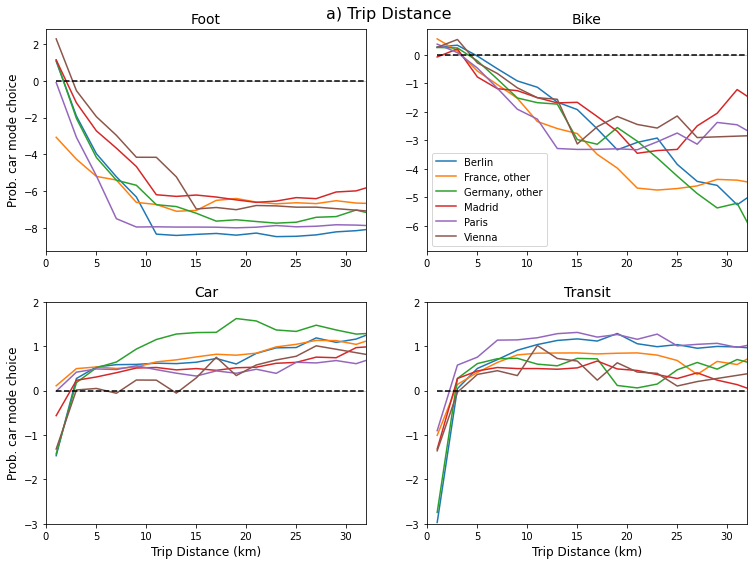

In [37]:
# plot binned values, with subplots per mode and values for each city in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
fig.tight_layout(pad=3.0)
feature_label='Trip Distance (km)'
fig.suptitle('a) Trip Distance', fontsize=16)
ax1 = plt.subplot(221)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Foot',], x='Group_mid', y='Shap_y', hue='City').set(title='Foot',ylabel='SHAP (mode Prob.)')
plt.title('Foot',fontsize=14)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Foot',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax1.set_xlim(0, 32);
ax1.get_legend().remove()
ax1.set_ylabel('Prob. car mode choice',fontsize=12)
ax1.set(xlabel=None)

ax2 = plt.subplot(222)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Bike',], x='Group_mid', y='Shap_y', hue='City').set(title='Bike', ylabel='SHAP (mode Prob.)')
plt.title('Bike',fontsize=14)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Bike',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax2.set_xlim(0, 32);
#ax2.set_ylabel('')
ax2.set(xlabel=None,ylabel=None)
#ax2.get_legend().remove()

ax3 = plt.subplot(223)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Car',], x='Group_mid', y='Shap_y', hue='City').set(title='Car', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Car',fontsize=14)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Car',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax3.set_xlim(0, 32);
ax3.set_ylim(-3, 2);
ax3.get_legend().remove()
ax3.set_ylabel('Prob. car mode choice',fontsize=12)

ax4 = plt.subplot(224)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Transit',], x='Group_mid', y='Shap_y', hue='City').set(title='Transit', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Transit',fontsize=14)
sns.lineplot(data=df_mean_tripd.loc[df_mean_tripd['Mode']=='Transit',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax4.set_xlim(0, 32);
ax4.set_ylim(-3, 2);
#ax4.set_ylabel('')
ax4.set(ylabel=None)
ax4.get_legend().remove()

plt.savefig('../outputs/ML_Results/result_figures/mode_common_new/' + feature_label.replace(' (km)','') +  '_all_bin.png',facecolor='w',dpi=300,bbox_inches='tight')
# plt.close() 

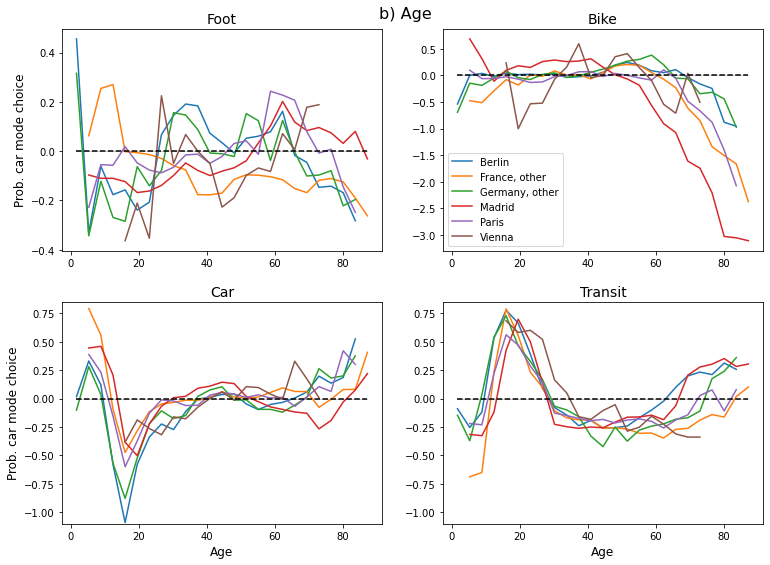

In [38]:
# plot binned values, with subplots per mode and values for each city in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
fig.tight_layout(pad=3.0)
feature_label='Age'
fig.suptitle('b) Age', fontsize=16)
ax1 = plt.subplot(221)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Foot',], x='Group_mid', y='Shap_y', hue='City').set(title='Foot',ylabel='SHAP (mode Prob.)')
plt.title('Foot',fontsize=14)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Foot',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
#ax1.set_xlim(0, 32);
ax1.get_legend().remove()
ax1.set_ylabel('Prob. car mode choice',fontsize=12)
ax1.set(xlabel=None)

ax2 = plt.subplot(222)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Bike',], x='Group_mid', y='Shap_y', hue='City').set(title='Bike', ylabel='SHAP (mode Prob.)')
plt.title('Bike',fontsize=14)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Bike',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
#ax2.set_xlim(0, 32);
#ax2.set_ylabel('')
ax2.set(xlabel=None,ylabel=None)
#ax2.get_legend().remove()

ax3 = plt.subplot(223)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Car',], x='Group_mid', y='Shap_y', hue='City').set(title='Car', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Car',fontsize=14)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Car',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
#ax3.set_xlim(0, 32);
ax3.set_ylim(-1.1,0.85 );
ax3.get_legend().remove()
ax3.set_ylabel('Prob. car mode choice',fontsize=12)

ax4 = plt.subplot(224)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Transit',], x='Group_mid', y='Shap_y', hue='City').set(title='Transit', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Transit',fontsize=14)
sns.lineplot(data=df_mean_age.loc[df_mean_age['Mode']=='Transit',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
#ax4.set_xlim(0, 32);
ax4.set_ylim(-1.1,0.85 );
#ax4.set_ylabel('')
ax4.set(ylabel=None)
ax4.get_legend().remove()
plt.savefig('../outputs/ML_Results/result_figures/mode_common_new/' + feature_label.replace(' (km)','') +  '_all_bin.png',facecolor='w',dpi=300,bbox_inches='tight')


In [30]:
df_mean_pdens['Group_mid']=0.01*df_mean_pdens['Group_mid']
df_mean_pdens

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,UrbPopDensity_res,Bike,13.100730,0.024658,0
1,Berlin,UrbPopDensity_res,Bike,38.828835,0.093765,0
2,Berlin,UrbPopDensity_res,Bike,64.239305,-0.053136,0
3,Berlin,UrbPopDensity_res,Bike,89.649775,-0.132488,0
4,Berlin,UrbPopDensity_res,Bike,115.060245,-0.184146,0
...,...,...,...,...,...,...
307,Vienna,UrbPopDensity_res,Transit,140.470715,0.241931,0
308,Vienna,UrbPopDensity_res,Transit,165.881185,0.255323,0
309,Vienna,UrbPopDensity_res,Transit,191.291655,0.329174,0
310,Vienna,UrbPopDensity_res,Transit,216.702125,0.282992,0


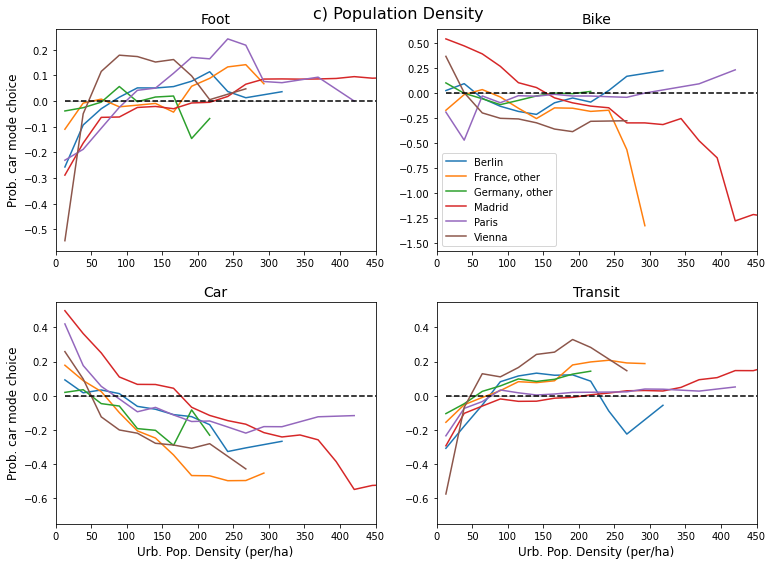

In [41]:
# plot binned values, with subplots per mode and values for each city in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
fig.tight_layout(pad=3.0)
feature_label='Urb. Pop. Density (per/ha)'
fig.suptitle('c) Population Density', fontsize=16)
ax1 = plt.subplot(221)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Foot',], x='Group_mid', y='Shap_y', hue='City').set(title='Foot',ylabel='SHAP (mode Prob.)')
plt.title('Foot',fontsize=14)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Foot',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax1.set_xlim(0, 450);
ax1.get_legend().remove()
ax1.set_ylabel('Prob. car mode choice',fontsize=12)
ax1.set(xlabel=None)

ax2 = plt.subplot(222)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Bike',], x='Group_mid', y='Shap_y', hue='City').set(title='Bike', ylabel='SHAP (mode Prob.)')
plt.title('Bike',fontsize=14)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Bike',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax2.set_xlim(0, 450);
#ax2.set_ylabel('')
ax2.set(xlabel=None,ylabel=None)
#ax2.get_legend().remove()

ax3 = plt.subplot(223)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Car',], x='Group_mid', y='Shap_y', hue='City').set(title='Car', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Car',fontsize=14)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Car',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax3.set_xlim(0, 450);
ax3.set_ylim(-0.75,0.55 );
ax3.get_legend().remove()
ax3.set_ylabel('Prob. car mode choice',fontsize=12)

ax4 = plt.subplot(224)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Transit',], x='Group_mid', y='Shap_y', hue='City').set(title='Transit', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Transit',fontsize=14)
sns.lineplot(data=df_mean_pdens.loc[df_mean_pdens['Mode']=='Transit',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax4.set_xlim(0, 450);
ax4.set_ylim(-0.75,0.55 );
#ax4.set_ylabel('')
ax4.set(ylabel=None)
ax4.get_legend().remove()
plt.savefig('../outputs/ML_Results/result_figures/mode_common_new/' + feature_label.replace(' (per/ha)','') +  '_all_bin.png',facecolor='w',dpi=300,bbox_inches='tight')


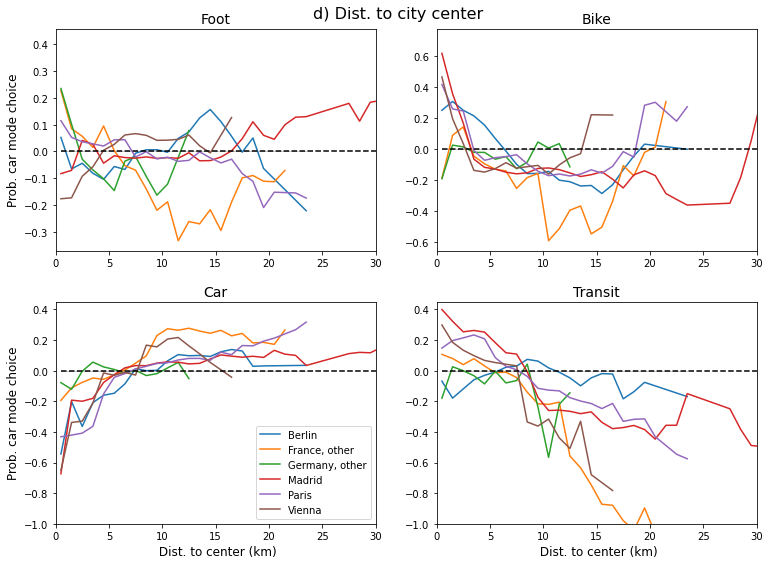

In [42]:
# plot binned values, with subplots per mode and values for each city in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
fig.tight_layout(pad=3.0)
feature_label=' Dist. to center (km)'
fig.suptitle('d) Dist. to city center', fontsize=16)
ax1 = plt.subplot(221)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Foot',], x='Group_mid', y='Shap_y', hue='City').set(title='Foot',ylabel='SHAP (mode Prob.)')
plt.title('Foot',fontsize=14)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Foot',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax1.set_xlim(0, 30);
ax1.get_legend().remove()
ax1.set_ylabel('Prob. car mode choice',fontsize=12)
ax1.set(xlabel=None)

ax2 = plt.subplot(222)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Bike',], x='Group_mid', y='Shap_y', hue='City').set(title='Bike', ylabel='SHAP (mode Prob.)')
plt.title('Bike',fontsize=14)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Bike',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax2.set_xlim(0, 30);
#ax2.set_ylabel('')
ax2.set(xlabel=None,ylabel=None)
ax2.get_legend().remove()

ax3 = plt.subplot(223)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Car',], x='Group_mid', y='Shap_y', hue='City').set(title='Car', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Car',fontsize=14)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Car',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax3.set_xlim(0, 30);
ax3.set_ylim(-1,0.45 );
#ax3.get_legend().remove()
ax3.set_ylabel('Prob. car mode choice',fontsize=12)

ax4 = plt.subplot(224)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Transit',], x='Group_mid', y='Shap_y', hue='City').set(title='Transit', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Transit',fontsize=14)
sns.lineplot(data=df_mean_d2c.loc[df_mean_d2c['Mode']=='Transit',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax4.set_xlim(0, 30);
ax4.set_ylim(-1,0.45 );
#ax4.set_ylabel('')
ax4.set(ylabel=None)
ax4.get_legend().remove()
plt.savefig('../outputs/ML_Results/result_figures/mode_common_new/' + feature_label.replace(' (km)','') +  '_all_bin.png',facecolor='w',dpi=300,bbox_inches='tight')

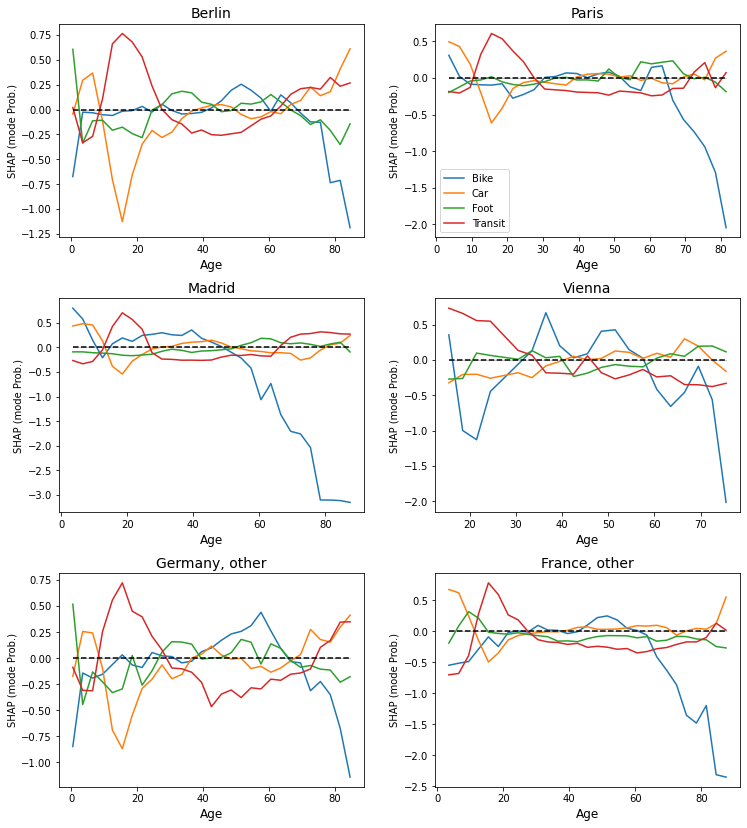

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,12))
fig.tight_layout(pad=4.0)

ax1 = plt.subplot(321)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Berlin',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Berlin',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Berlin',fontsize=14)
ax1.get_legend().remove()

ax2 = plt.subplot(322)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Paris',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Paris',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Paris',fontsize=14)
#ax2.get_legend().remove()

ax3 = plt.subplot(323)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Madrid',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Madrid',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Madrid',fontsize=14)
ax3.get_legend().remove()

ax4 = plt.subplot(324)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Vienna',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Vienna',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Vienna',fontsize=14)
ax4.get_legend().remove()

ax5 = plt.subplot(325)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Germany, other',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Germany, other',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Germany, other',fontsize=14)
ax5.get_legend().remove()

ax6 = plt.subplot(326)
sns.lineplot(data=df_mean.loc[df_mean['City']=='France, other',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='France, other',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('France, other',fontsize=14)
ax6.get_legend().remove()
plt.savefig('../outputs/ML_Results/result_figures/mode_common_new/' + feature_label.replace(' (km)','') +  '_city_bin.png',facecolor='w',dpi=300,bbox_inches='tight')
# plt.close() 